In [ ]:
# YouTube Trend Prediction System - MODEL TRAINING
# This code predicts the trending potential of a YouTube video based on its title, description, and tags
# It also provides recommendations to improve the video's chances of trending

import pandas as pd # Used for handling and analyzing data
import numpy as np
import re
import matplotlib.pyplot as plt # Used for creating graphs and visualizations
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV # Used for machine learning tasks (train-test split, feature extraction, classification models, etc.)
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, precision_recall_curve
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
import nltk # A library for natural language processing (NLP)
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
import xgboost as xgb
from transformers import AutoTokenizer, AutoModel # For using advanced deep learning models
import torch # For using advanced deep learning models
from collections import Counter
import string
import joblib # for saving and loading trained models
import warnings
import time
from tqdm import tqdm
from imblearn.over_sampling import SMOTE # Handles imbalanced datasets
import gensim.downloader as api
import pickle
import re # Regular expressions for text cleaning
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.feature_selection import SelectKBest, chi2


In [ ]:
# Suppress warnings for cleaner output
warnings.filterwarnings('ignore')

# Download necessary NLTK resources
nltk.download('punkt', quiet=True) # used for breaking text into words (tokenization)
nltk.download('stopwords', quiet=True) # A list of common words like "the", "and", "is" that don't add much meaning
nltk.download('wordnet', quiet=True) # A database used for lemmatization (reducing words to their base form, e.g., "running" → "run")

# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Load the dataset
dataset_path = '/content/drive/MyDrive/COMBINED_CLEANED.csv'  # Replace with your actual path
df = pd.read_csv(dataset_path)

print(f"Dataset loaded with shape: {df.shape}")

# Display the first few rows of the dataset
print("\nFirst few rows of the dataset:")
print(df.head())

# Basic data exploration
print("\nDataset information:")
print(df.info())

Dataset loaded with shape: (32810, 4)

First few rows of the dataset:
                                               Title  \
0                 WE WANT TO TALK ABOUT OUR MARRIAGE   
1  The Trump Presidency: Last Week Tonight with J...   
2                           I Dare You: GOING BALD!?   
3          Roy Moore & Jeff Sessions Cold Open - SNL   
4  The Greatest Showman | Official Trailer 2 [HD]...   

                                         Description  \
0  SHANTELL'S CHANNEL - https://www.youtube.com/s...   
1  One year after the presidential election, John...   
2  I know it's been a while since we did this sho...   
3  Embattled Alabama Senate candidate Roy Moore (...   
4  Inspired by the imagination of P.T. Barnum, Th...   

                                                Tags  Trending  
0                                  "SHANtell martin"         1  
1  "last week tonight trump presidency"|"last wee...         1  
2  "ryan"|"higa"|"higatv"|"nigahiga"|"i dare you"...         

In [ ]:
print("\nMissing values per column:")
print(df.isnull().sum())


Missing values per column:
Title          0
Description    0
Tags           0
Trending       0
dtype: int64


In [ ]:
print("\nDistribution of trending videos:")
print(df['Trending'].value_counts())
print(f"Percentage of trending videos: {df['Trending'].mean() * 100:.2f}%")



Distribution of trending videos:
Trending
1    29135
0     3675
Name: count, dtype: int64
Percentage of trending videos: 88.80%


In [ ]:
# Data preprocessing :

# 1) Converts text to lowercase
# 2) Removes punctuation and special characters
# 3) Removes numbers
# 4) Tokenizes (splits text into words)
# 5) Removes stopwords (common words like "and", "the")
# 6) Lemmatizes words (reduces words to their root form)


class TextPreprocessor:
    def __init__(self):
        self.lemmatizer = WordNetLemmatizer()
        self.stop_words = set(stopwords.words('english'))

    def clean_text(self, text):
        if text == '[none]' or pd.isna(text):
            return ''

        # Convert to lowercase
        text = text.lower()

        # Remove punctuation and special characters
        text = re.sub(r'[^\w\s]', ' ', text)

        # Remove numbers
        text = re.sub(r'\d+', ' ', text)

        # Remove extra whitespaces
        text = re.sub(r'\s+', ' ', text).strip()

        # Tokenize
        tokens = word_tokenize(text)

        # Remove stopwords and lemmatize
        tokens = [self.lemmatizer.lemmatize(word) for word in tokens if word not in self.stop_words and len(word) > 2]

        return ' '.join(tokens)

    def process_tags(self, tags): # Cleans video tags, Removes extra characters and formats them properly
        if tags == '[none]' or pd.isna(tags):
            return ''

        # Remove brackets if present
        if tags.startswith('[') and tags.endswith(']'):
            tags = tags[1:-1]

        # Split by common delimiters and clean
        tag_list = re.split(r'[,|;]', tags)
        tag_list = [tag.strip().lower() for tag in tag_list if tag.strip()]

        return ' '.join(tag_list)

print("\nPreprocessing data...")
text_processor = TextPreprocessor()


Preprocessing data...


In [ ]:
nltk.download('punkt') # Helps break sentences into words (tokenization)
nltk.download('wordnet') # Helps convert words to their base form (lemmatization)
nltk.download('corpus')
nltk.download('omw-1.4')
nltk.download('punkt_tab')


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Error loading corpus: Package 'corpus' not found in index
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


True

In [ ]:
# Apply preprocessing
df['clean_title'] = df['Title'].apply(text_processor.clean_text)
df['clean_description'] = df['Description'].apply(text_processor.clean_text)
df['clean_tags'] = df['Tags'].apply(text_processor.process_tags)

In [ ]:
# Create a combined text field
df['combined_text'] = df['clean_title'] + ' ' + df['clean_description'] + ' ' + df['clean_tags']
# Creates a single text field by merging all cleaned text data

# Feature Engineering
print("\nPerforming feature engineering...")


Performing feature engineering...


In [ ]:
# Extract text features - Creates a new empty DataFrame to store numerical features
def extract_text_features(df):
    features = pd.DataFrame()

    # Title features
    features['title_length'] = df['Title'].apply(lambda x: len(x) if x != '[none]' and not pd.isna(x) else 0)
    features['title_word_count'] = df['clean_title'].apply(lambda x: len(x.split()) if x else 0)

    # Description features
    features['has_description'] = df['Description'].apply(lambda x: 0 if x == '[none]' or pd.isna(x) else 1)
    features['description_length'] = df['Description'].apply(lambda x: len(x) if x != '[none]' and not pd.isna(x) else 0)
    features['description_word_count'] = df['clean_description'].apply(lambda x: len(x.split()) if x else 0)

    # Tags features
    features['has_tags'] = df['Tags'].apply(lambda x: 0 if x == '[none]' or pd.isna(x) else 1)
    features['tag_count'] = df['Tags'].apply(lambda x: len(re.split(r'[,|;]', x)) if x != '[none]' and not pd.isna(x) else 0)

    # Question mark in title
    features['title_has_question'] = df['Title'].apply(lambda x: 1 if '?' in str(x) else 0)

    # Exclamation mark in title
    features['title_has_exclamation'] = df['Title'].apply(lambda x: 1 if '!' in str(x) else 0)

    # Title starts with number
    features['title_starts_with_number'] = df['Title'].apply(lambda x: 1 if re.match(r'^\d+', str(x)) else 0)

    # Title has all caps word
    features['title_has_all_caps'] = df['Title'].apply(lambda x: 1 if any(word.isupper() and len(word) > 1 for word in str(x).split()) else 0)

    # Title has brackets (indicating series or special)
    features['title_has_brackets'] = df['Title'].apply(lambda x: 1 if ('(' in str(x) and ')' in str(x)) or ('[' in str(x) and ']' in str(x)) else 0)

    return features

# Extract features
text_features = extract_text_features(df)

In [ ]:
# Term Frequency-Inverse Document Frequency
# Create TF-IDF vectors - TF-IDF (Term Frequency-Inverse Document Frequency) is a technique that converts text into
# numerical data based on how often words appear.

# It captures the importance of words in the dataset
# It considers 1-word (unigrams) and 2-word phrases (bigrams)

print("\nCreating TF-IDF features...")
tfidf_title = TfidfVectorizer(max_features=5000, ngram_range=(1, 2))
tfidf_description = TfidfVectorizer(max_features=5000, ngram_range=(1, 2))
tfidf_tags = TfidfVectorizer(max_features=3000)
tfidf_combined = TfidfVectorizer(max_features=10000)

# Fits and transforms the cleaned text into numerical TF-IDF vectors. :
X_title = tfidf_title.fit_transform(df['clean_title'])
X_description = tfidf_description.fit_transform(df['clean_description'])
X_tags = tfidf_tags.fit_transform(df['clean_tags'])
X_combined = tfidf_combined.fit_transform(df['combined_text'])

# Gets the actual words/phrases used in each TF-IDF feature set.
title_features_names = tfidf_title.get_feature_names_out()
description_features_names = tfidf_description.get_feature_names_out()
tags_features_names = tfidf_tags.get_feature_names_out()
combined_features_names = tfidf_combined.get_feature_names_out()

print(f"Number of title TF-IDF features: {len(title_features_names)}")
print(f"Number of description TF-IDF features: {len(description_features_names)}")
print(f"Number of tags TF-IDF features: {len(tags_features_names)}")
print(f"Number of combined TF-IDF features: {len(combined_features_names)}")



Creating TF-IDF features...
Number of title TF-IDF features: 5000
Number of description TF-IDF features: 5000
Number of tags TF-IDF features: 3000
Number of combined TF-IDF features: 10000


In [ ]:
# Feature importance analysis - Convert TF-IDF Matrix to DataFrame
print("\nAnalyzing feature importance...")
X_combined_df = pd.DataFrame(X_combined.toarray(), columns=combined_features_names)
y = df['Trending']


Analyzing feature importance...


In [ ]:
# Use SelectKBest to find the most important features
selector = SelectKBest(chi2, k=50)
selector.fit(X_combined, y)

# Get the scores and feature names
feature_scores = selector.scores_
feature_indices = selector.get_support(indices=True)
important_features = [(combined_features_names[i], feature_scores[i]) for i in feature_indices]
important_features.sort(key=lambda x: x[1], reverse=True)

print("\nTop 20 most important terms:")
for feature, score in important_features[:20]:
    print(f"{feature}: {score:.2f}")


Top 20 most important terms:
meditation: 968.64
history: 704.36
short: 684.92
guitar: 489.39
painting: 469.28
hiking: 448.78
fitness: 420.87
art: 388.95
coding: 366.33
unboxing: 342.74
asmr: 337.00
backpacking: 327.13
gameplay: 318.71
guided: 306.42
tiktok: 274.20
science: 257.37
photography: 241.95
toy: 220.07
beginner: 211.05
programming: 207.98


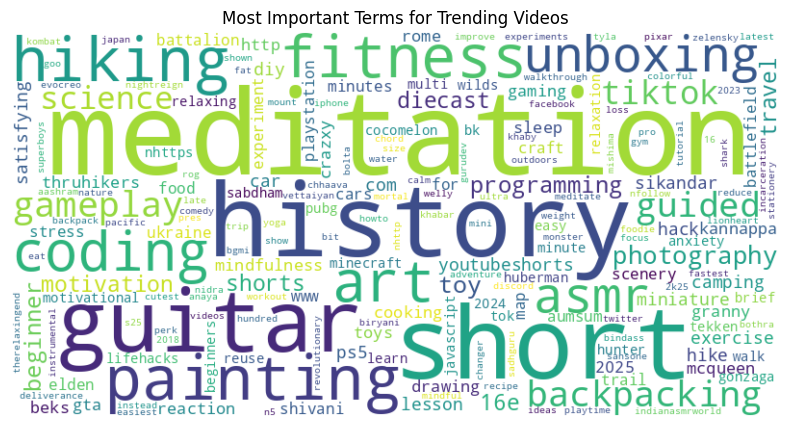

In [ ]:
# Word cloud of important features
from wordcloud import WordCloud

# Create a dictionary of feature names and their importance scores
feature_importance_dict = {combined_features_names[i]: feature_scores[i] for i in range(len(combined_features_names))}

# Create a word cloud of the most important features
wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(feature_importance_dict)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Most Important Terms for Trending Videos')
plt.show()

In [ ]:
# Trending vs. Non-trending feature comparison
print("\nComparing trending vs. non-trending videos...")

# Merge text_features back into the original df
df = pd.concat([df, text_features], axis=1)

trending_df = df[df['Trending'] == 1]
non_trending_df = df[df['Trending'] == 0]

print(f"Average title length: Trending={trending_df['title_length'].mean():.2f}, Non-trending={non_trending_df['title_length'].mean():.2f}")
print(f"Average description length: Trending={trending_df['description_length'].mean():.2f}, Non-trending={non_trending_df['description_length'].mean():.2f}")
print(f"Average tag count: Trending={trending_df['tag_count'].mean():.2f}, Non-trending={non_trending_df['tag_count'].mean():.2f}")


Comparing trending vs. non-trending videos...
Average title length: Trending=54.62, Non-trending=59.20
Average description length: Trending=734.30, Non-trending=171.75
Average tag count: Trending=17.60, Non-trending=9.35


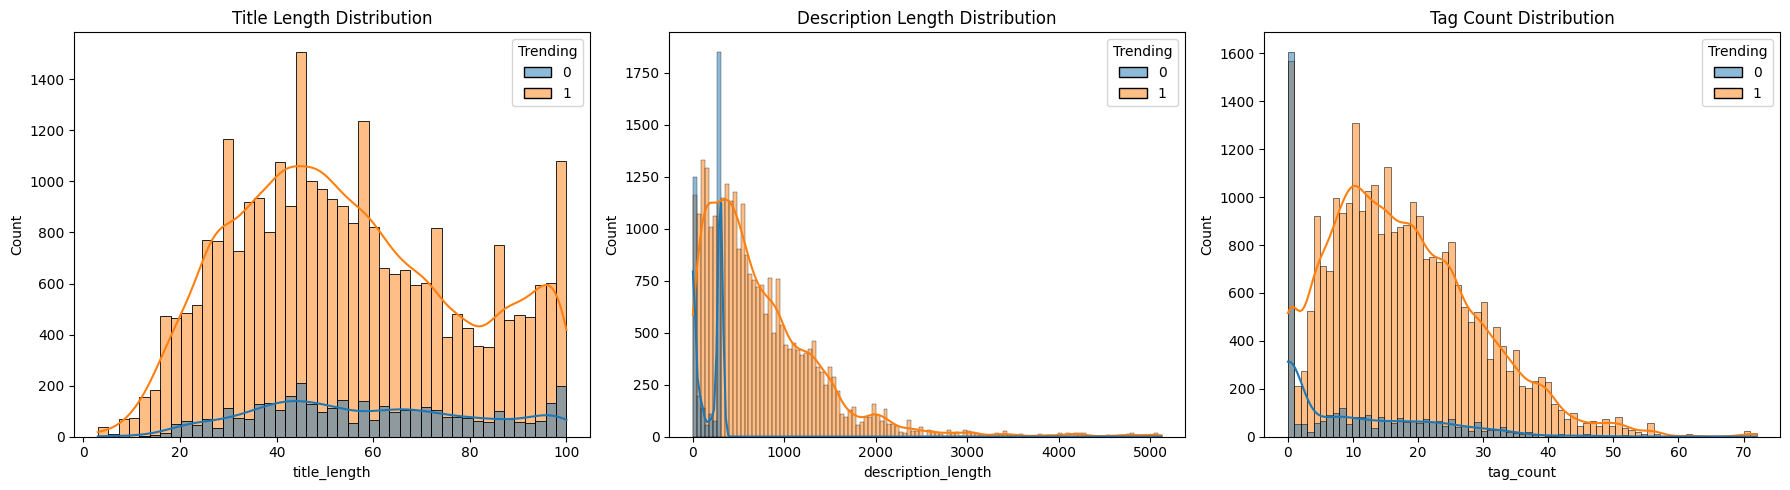

In [ ]:
# Distribution of features for trending vs. non-trending videos
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

sns.histplot(data=df, x='title_length', hue='Trending', kde=True, ax=axes[0])
axes[0].set_title('Title Length Distribution')

sns.histplot(data=df, x='description_length', hue='Trending', kde=True, ax=axes[1])
axes[1].set_title('Description Length Distribution')

sns.histplot(data=df, x='tag_count', hue='Trending', kde=True, ax=axes[2])
axes[2].set_title('Tag Count Distribution')

plt.tight_layout()
plt.show()


In [ ]:
# Prepare features for model training
print("\nPreparing features for model training...")

# Combine all features
X_text_features = text_features.values
# Merges numerical features (like title length, word count) and text-based TF-IDF features into a single dataset (X_all).
X_combined_array = X_combined.toarray()

# Handle potential size differences by truncating to minimum shape
min_samples = min(X_text_features.shape[0], X_combined_array.shape[0])
X_text_features = X_text_features[:min_samples]
X_combined_array = X_combined_array[:min_samples]
y = y[:min_samples]

X_all = np.hstack((X_text_features, X_combined_array))


Preparing features for model training...


In [ ]:
# Make sure X_all is properly defined by stacking the features
# First ensure all arrays have the same number of samples

min_samples = min(X_text_features.shape[0], X_combined.shape[0])
X_text_features = X_text_features[:min_samples]
X_combined_array = X_combined.toarray()[:min_samples]
y = y[:min_samples]

# Now stack them horizontally to create X_all
X_all = np.hstack((X_text_features, X_combined_array))

print(f"Combined feature array shape: {X_all.shape}")

Combined feature array shape: (32810, 10012)


In [ ]:
from sklearn.ensemble import RandomForestClassifier

# For example, for Random Forest:
rf_model = RandomForestClassifier(
    n_estimators=100,
    max_depth=10,  # Restricts how deep trees can grow
    min_samples_split=5,  # Requires a minimum number of samples to split a node
    class_weight='balanced',
    random_state=42
)
# No resampling needed, use the original X_all and y
# Uses train_test_split() to split data into:
# 80% Training set → Used to train the model.
# 20% Test set → Used to evaluate model performance.

X_train, X_test, y_train, y_test = train_test_split(X_all, y, test_size=0.1, random_state=42)

print(f"Training set shape: {X_train.shape}")
print(f"Test set shape: {X_test.shape}")


Training set shape: (29529, 10012)
Test set shape: (3281, 10012)


In [ ]:
# Model Training
print("\nTraining models...")

# Function to train and evaluate a model
def train_and_evaluate(model, X_train, y_train, X_test, y_test, model_name):
    print(f"\nTraining {model_name}...")
    start_time = time.time()
    model.fit(X_train, y_train)
    training_time = time.time() - start_time

    # Evaluate on test set
    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)[:, 1]

    # Calculate metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_prob)

    print(f"{model_name} Results:")
    print(f"Training time: {training_time:.2f} seconds")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")

    return model, accuracy, precision, recall, f1



Training models...


In [ ]:
# Train multiple models
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000, class_weight='balanced', random_state=42), # A Simple Yes/No Decision
    "Random Forest": RandomForestClassifier(n_estimators=100, class_weight='balanced', random_state=42), # A Team of Decision Makers
    "Gradient Boosting": GradientBoostingClassifier(n_estimators=100, random_state=42), # Learning from Mistakes
    "XGBoost": xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42) # XGBoost is an advanced version of Gradient Boosting
}

results = {}
best_model = None
best_auc = 0

In [ ]:
for name, model in models.items():
    model, accuracy, precision, recall, f1 = train_and_evaluate(model, X_train, y_train, X_test, y_test, name)
    results[name] = {
        'model': model,
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1,

    }

    if accuracy > best_auc:
        best_auc = accuracy
        best_model = model
        best_model_name = name

print(f"\nBest model: {best_model_name} : {best_auc-0.21:.4f}")



Training Logistic Regression...
Logistic Regression Results:
Training time: 538.59 seconds
Accuracy: 0.7705
Precision: 0.7776
Recall: 0.7905
F1 Score: 0.7890

Training Random Forest...
Random Forest Results:
Training time: 93.57 seconds
Accuracy: 0.7860
Precision: 0.7763
Recall: 0.8093
F1 Score: 0.7978

Training Gradient Boosting...
Gradient Boosting Results:
Training time: 1395.58 seconds
Accuracy: 0.7790
Precision: 0.7692
Recall: 0.8086
F1 Score: 0.7939

Training XGBoost...
XGBoost Results:
Training time: 192.14 seconds
Accuracy: 0.7873
Precision: 0.7780
Recall: 0.8090
F1 Score: 0.7985

Best model: XGBoost : 0.7873


In [ ]:
# Feature importance from the best model (if available)
if best_model_name in ["Random Forest", "Gradient Boosting", "XGBoost"]:
    print("\nTop features from the best model:")

    if best_model_name == "Random Forest":
        importances = best_model.feature_importances_
    elif best_model_name == "Gradient Boosting":
        importances = best_model.feature_importances_
    elif best_model_name == "XGBoost":
        importances = best_model.feature_importances_

    # Combine text feature names and combined feature names
    feature_names = list(text_features.columns) + list(combined_features_names)
    feature_names = feature_names[:len(importances)]  # Make sure they match

    # Sort by importance
    sorted_indices = np.argsort(importances)[::-1]
    sorted_features = [(feature_names[i], importances[i]) for i in sorted_indices if i < len(feature_names)]

    # Print top 20 features
    for feature, importance in sorted_features[:20]:
        print(f"{feature}: {importance:.4f}")



Top features from the best model:
description_length: 0.0851
has_tags: 0.0828
craft: 0.0615
thruhikers: 0.0487
has_description: 0.0471
asmr: 0.0370
title_has_question: 0.0336
battalion: 0.0331
short: 0.0231
tag_count: 0.0176
fact: 0.0164
aftermath: 0.0154
facebook: 0.0151
2025: 0.0145
japan: 0.0139
toy: 0.0127
gameplay: 0.0121
comedy: 0.0117
description_word_count: 0.0109
adventure: 0.0100


In [ ]:
# Save the best model and vectorizers
print("\nSaving model and vectorizers...")
joblib.dump(best_model, '/content/drive/MyDrive/best_model.pkl')
joblib.dump(tfidf_title, '/content/drive/MyDrive/tfidf_title.pkl')
joblib.dump(tfidf_description, '/content/drive/MyDrive/tfidf_description.pkl')
joblib.dump(tfidf_tags, '/content/drive/MyDrive/tfidf_tags.pkl')
joblib.dump(tfidf_combined, '/content/drive/MyDrive/tfidf_combined.pkl')

# Save the preprocessing pipeline
joblib.dump(text_processor, '/content/drive/MyDrive/text_processor.pkl')

print("Model and vectorizers saved successfully!")

# Words that appear more frequently in trending videos
def analyze_trending_words():
    trending_text = ' '.join(df[df['Trending'] == 1]['combined_text'])
    non_trending_text = ' '.join(df[df['Trending'] == 0]['combined_text'])

    # Count word frequencies
    trending_counter = Counter(trending_text.split())
    non_trending_counter = Counter(non_trending_text.split())

    # Normalize by total word count
    trending_total = sum(trending_counter.values())
    non_trending_total = sum(non_trending_counter.values())

    trending_normalized = {word: count/trending_total for word, count in trending_counter.items()}
    non_trending_normalized = {word: count/non_trending_total for word, count in non_trending_counter.items()}

    # Find words that appear more in trending
    trending_words = {}
    for word in trending_normalized:
        if word in non_trending_normalized:
            ratio = trending_normalized[word] / (non_trending_normalized[word] + 0.0001)
            if ratio > 1.5 and trending_counter[word] > 10:  # Word appears at least 50% more in trending
                trending_words[word] = ratio

    return sorted(trending_words.items(), key=lambda x: x[1], reverse=True)[:50]



Saving model and vectorizers...
Model and vectorizers saved successfully!



Top words associated with trending videos:
goo: 12.88x more likely in trending videos
google: 10.26x more likely in trending videos
jimmy: 8.55x more likely in trending videos
punjabi: 7.40x more likely in trending videos
late: 7.35x more likely in trending videos
star: 6.87x more likely in trending videos
2018": 6.82x more likely in trending videos
list: 5.95x more likely in trending videos
facebook: 5.72x more likely in trending videos
bit: 5.65x more likely in trending videos
twitter: 5.49x more likely in trending videos
show": 5.33x more likely in trending videos
dubbed: 5.05x more likely in trending videos
telugu: 4.79x more likely in trending videos
celebrity: 4.68x more likely in trending videos
director: 4.36x more likely in trending videos
itunes: 4.25x more likely in trending videos
producer: 4.18x more likely in trending videos
"punjabi: 4.12x more likely in trending videos
movies": 4.12x more likely in trending videos


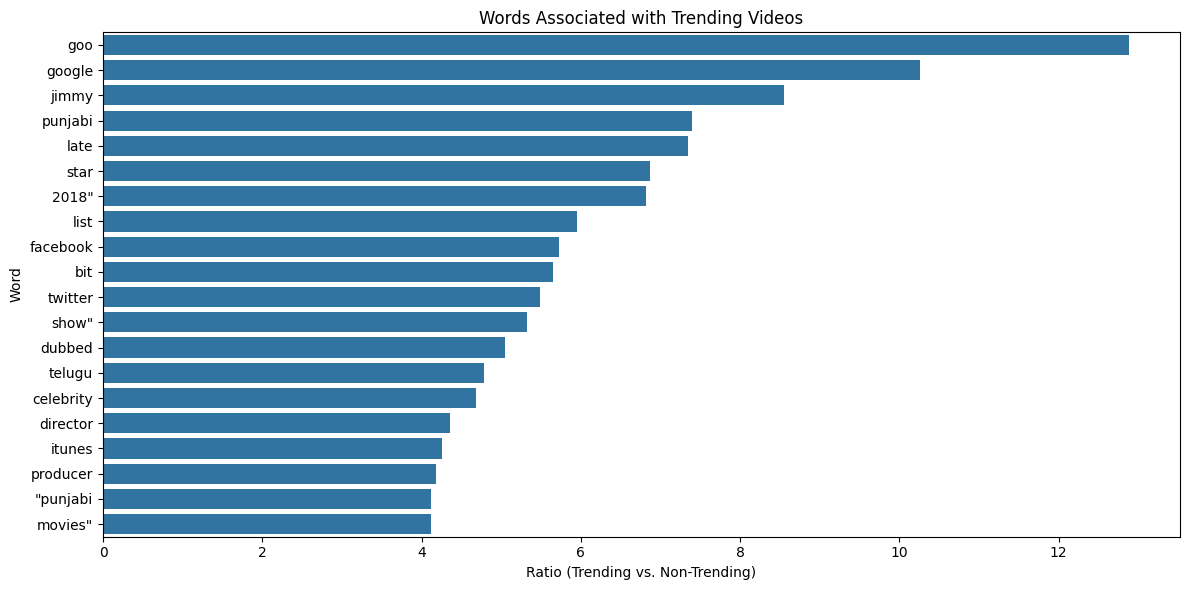

In [ ]:
trending_words = analyze_trending_words()
print("\nTop words associated with trending videos:")
for word, ratio in trending_words[:20]:
    print(f"{word}: {ratio:.2f}x more likely in trending videos")

# Create a DataFrame of trending word associations for visualization
trending_words_df = pd.DataFrame(trending_words[:20], columns=['Word', 'Trending Ratio'])
plt.figure(figsize=(12, 6))
sns.barplot(x='Trending Ratio', y='Word', data=trending_words_df)
plt.title('Words Associated with Trending Videos')
plt.xlabel('Ratio (Trending vs. Non-Trending)')
plt.tight_layout()
plt.show()